# Reject uncertain predictions

An example application of well-calibrated prediction uncertainty is the rejection of uncertain predictions.
We define an uncertainty threshold $ \mathcal{H}_{\mathrm{max}} $ and reject all predictions from the test set where $ \tilde{\mathcal{H}}(\mathbf{p}) > \mathcal{H}_{\mathrm{max}} $.
An increase in the accuracy of the remaining test set predictions is expected.
Let's create a figure that shows the top-1 error as a function of decreasing $ \mathcal{H}_{\mathrm{max}} $.

In [1]:
%matplotlib notebook
import numpy as np
np.random.seed(0)
import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib
from tqdm import tqdm
from ece import eceloss, uceloss
from utils import accuracy, nentr
from models import BayesianNet
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.size'] = 8

In [2]:
batch_size = 128
valid_size = 5000

mean = [0.4914, 0.48216, 0.44653]
std = [0.2470, 0.2435, 0.26159]
valid_set_18 = datasets.CIFAR10('../data', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.RandomCrop(32, padding=4),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=mean, std=std)]))

test_set_18 = datasets.CIFAR10('../data', train=False, download=False,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean, std=std)]))
valid_indices_18 = torch.load('./valid_indices_cifar10.pth')

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
valid_set = datasets.CIFAR100('../data', train=True, download=True,
                              transform=transforms.Compose([
                                  transforms.RandomCrop(32, padding=4),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=mean, std=std)]))

test_set = datasets.CIFAR100('../data', train=False, download=False,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=mean, std=std)]))
valid_indices = torch.load('./valid_indices_cifar100.pth')

valid_loader_18 = torch.utils.data.DataLoader(valid_set_18, batch_size=batch_size, pin_memory=True,
                                           sampler=SubsetRandomSampler(valid_indices_18))
test_loader_18 = torch.utils.data.DataLoader(test_set_18, batch_size=batch_size, pin_memory=True, num_workers=4)

valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, pin_memory=True,
                                           sampler=SubsetRandomSampler(valid_indices))
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, pin_memory=True, num_workers=4)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Files already downloaded and verified
Files already downloaded and verified


In [3]:
print(device)
resnet18 = BayesianNet(num_classes=10, model='resnet18').to(device)
resnet101 = BayesianNet(num_classes=100, model='resnet101').to(device)
densenet169 = BayesianNet(num_classes=100, model='densenet169').to(device)

checkpoint = torch.load(f'../snapshots/resnet18_499.pth.tar', map_location=device)
print("Loading previous weights at epoch " + str(checkpoint['epoch']))
resnet18.load_state_dict(checkpoint['state_dict'])

checkpoint = torch.load(f'../snapshots/resnet101_499.pth.tar', map_location=device)
print("Loading previous weights at epoch " + str(checkpoint['epoch']))
resnet101.load_state_dict(checkpoint['state_dict'])

checkpoint = torch.load(f'../snapshots/densenet169_499.pth.tar', map_location=device)
print("Loading previous weights at epoch " + str(checkpoint['epoch']))
densenet169.load_state_dict(checkpoint['state_dict'])

cuda:0
Loading previous weights at epoch 499
Loading previous weights at epoch 499
Loading previous weights at epoch 499


<All keys matched successfully>

In [4]:
def train(net, bayesian, valid_loader):
    optimizer = optim.Adam([net.T], lr=1e-2, weight_decay=0)
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.1)
    train_losses = []
    train_accuracies = []
    epochs = 30

    for e in range(epochs):
        net.eval()

        epoch_train_loss = []
        epoch_train_acc = []
        is_best = False

        for batch_idx, (data, target) in enumerate(valid_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = net(data, temp_scale=True, bayesian=bayesian)
            if bayesian:
                output = torch.log_softmax(output, dim=2)
                output = output.mean(dim=0)
                loss = F.nll_loss(output, target)
            else:
                loss = F.cross_entropy(output, target)
            loss.backward()
            epoch_train_loss.append(loss.item())
            epoch_train_acc.append(accuracy(output, target))
            optimizer.step()

        epoch_train_loss = np.mean(epoch_train_loss)
        epoch_train_acc = np.mean(epoch_train_acc)
        lr_scheduler.step(epoch_train_loss)

        # save epoch losses
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        print("Epoch {:2d}, lr: {:.4f}, loss: {:.4f}, acc: {:.4f}, T: {:.4f}"
              .format(e,
                      optimizer.param_groups[0]['lr'],
                      epoch_train_loss,
                      epoch_train_acc,
                      net.T.item()
                      ))

In [5]:
#train(resnet18, bayesian=True, valid_loader=valid_loader_18)
resnet18.T = torch.nn.Parameter(torch.tensor([2.3643]).to(device))

#train(resnet101, bayesian=True, valid_loader=valid_loader)
resnet101.T = torch.nn.Parameter(torch.tensor([2.4711]).to(device))

#train(densenet169, bayesian=True, valid_loader=valid_loader)
densenet169.T = torch.nn.Parameter(torch.tensor([2.7556]).to(device))

In [6]:
def test(net, temp_scale, bayesian, test_loader):
    logits = []
    labels = []
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(tqdm(test_loader)):
            data, target = data.to(device), target.to(device)
            output = net(data, temp_scale=temp_scale, bayesian=bayesian)
            if bayesian:
                output = torch.softmax(output, dim=2).mean(dim=0)
            else:
                output = torch.softmax(output, dim=1)
            logits.append(output.detach())
            labels.append(target.detach())
    return torch.cat(logits, dim=0), torch.cat(labels, dim=0)

In [7]:
softmaxes_uncalib1, labels1 = test(resnet18, temp_scale=False, bayesian=True, test_loader=test_loader_18)
softmaxes_uncalib2, labels2 = test(resnet101, temp_scale=False, bayesian=True, test_loader=test_loader)
softmaxes_uncalib3, labels3 = test(densenet169, temp_scale=False, bayesian=True, test_loader=test_loader)

100%|██████████| 79/79 [00:02<00:00, 33.55it/s]


In [9]:
_, predictions_uncalib1 = torch.max(softmaxes_uncalib1, 1)

uncert_thresholds1 = np.linspace(0.05, 1.0, 20)[::-1]
top1_errors_uncalib1 = []

for uncert_thresh in uncert_thresholds1:
    uncertainties = nentr(softmaxes_uncalib1, base=softmaxes_uncalib1.size(1))
    labels_filtered = labels1[torch.where(uncertainties <= uncert_thresh)]
    predictions_filtered = predictions_uncalib1[torch.where(uncertainties <= uncert_thresh)]
    errors = predictions_filtered.ne(labels_filtered).float().mean()
    top1_errors_uncalib1.append(errors.item())
###
_, predictions_uncalib2 = torch.max(softmaxes_uncalib2, 1)

uncert_thresholds2 = np.linspace(0.05, 1.0, 20)[::-1]
top1_errors_uncalib2 = []

for uncert_thresh in uncert_thresholds2:
    uncertainties = nentr(softmaxes_uncalib2, base=softmaxes_uncalib2.size(1))
    labels_filtered = labels2[torch.where(uncertainties <= uncert_thresh)]
    predictions_filtered = predictions_uncalib2[torch.where(uncertainties <= uncert_thresh)]
    errors = predictions_filtered.ne(labels_filtered).float().mean()
    top1_errors_uncalib2.append(errors.item())
###
_, predictions_uncalib3 = torch.max(softmaxes_uncalib3, 1)

uncert_thresholds3 = np.linspace(0.05, 1.0, 20)[::-1]
top1_errors_uncalib3 = []

for uncert_thresh in uncert_thresholds3:
    uncertainties = nentr(softmaxes_uncalib3, base=softmaxes_uncalib3.size(1))
    labels_filtered = labels3[torch.where(uncertainties <= uncert_thresh)]
    predictions_filtered = predictions_uncalib3[torch.where(uncertainties <= uncert_thresh)]
    errors = predictions_filtered.ne(labels_filtered).float().mean()
    top1_errors_uncalib3.append(errors.item())

In [10]:
softmaxes1, labels1 = test(resnet18, temp_scale=True, bayesian=True, test_loader=test_loader_18)
softmaxes2, labels2 = test(resnet101, temp_scale=True, bayesian=True, test_loader=test_loader)
softmaxes3, labels3 = test(densenet169, temp_scale=True, bayesian=True, test_loader=test_loader)

100%|██████████| 79/79 [00:02<00:00, 33.59it/s]


In [11]:
_, predictions1 = torch.max(softmaxes1, 1)

uncert_thresholds1 = np.linspace(0.05, 1.0, 20)[::-1]
top1_errors1 = []

for uncert_thresh in uncert_thresholds1:
    uncertainties = nentr(softmaxes1, base=softmaxes1.size(1))
    labels_filtered = labels1[torch.where(uncertainties <= uncert_thresh)]
    predictions_filtered = predictions1[torch.where(uncertainties <= uncert_thresh)]
    errors = predictions_filtered.ne(labels_filtered).float().mean()
    top1_errors1.append(errors.item())
###
_, predictions2 = torch.max(softmaxes2, 1)

uncert_thresholds2 = np.linspace(0.05, 1.0, 20)[::-1]
top1_errors2 = []

for uncert_thresh in uncert_thresholds2:
    uncertainties = nentr(softmaxes2, base=softmaxes2.size(1))
    labels_filtered = labels2[torch.where(uncertainties <= uncert_thresh)]
    predictions_filtered = predictions2[torch.where(uncertainties <= uncert_thresh)]
    errors = predictions_filtered.ne(labels_filtered).float().mean()
    top1_errors2.append(errors.item())
###
_, predictions3 = torch.max(softmaxes3, 1)

uncert_thresholds3 = np.linspace(0.05, 1.0, 20)[::-1]
top1_errors3 = []

for uncert_thresh in uncert_thresholds3:
    uncertainties = nentr(softmaxes3, base=softmaxes3.size(1))
    labels_filtered = labels3[torch.where(uncertainties <= uncert_thresh)]
    predictions_filtered = predictions3[torch.where(uncertainties <= uncert_thresh)]
    errors = predictions_filtered.ne(labels_filtered).float().mean()
    top1_errors3.append(errors.item())

<IPython.core.display.Javascript object>


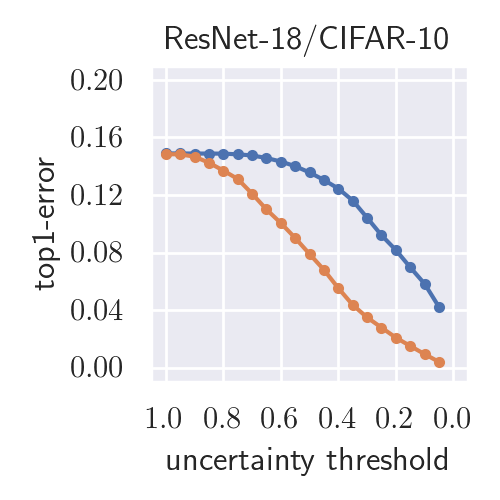

In [12]:
fig1, ax1 = plt.subplots(1, 1, figsize=(2.5, 2.5))
ax1.plot(uncert_thresholds1, top1_errors_uncalib1, marker='.')
ax1.plot(uncert_thresholds1, top1_errors1, marker='.')
ax1.set_xlabel(r'uncertainty threshold')
ax1.set_ylabel(r'top1-error')
ax1.set_xlim(1.05, -0.05)
ax1.set_ylim(-0.01, 0.21)
ax1.set_xticks((np.arange(0.0, 1.1, step=0.2)))
ax1.set_yticks((np.arange(0.0, 0.21, step=0.04)))
ax1.set_title(r'ResNet-18/CIFAR-10')
ax1.set_aspect(5)
fig1.tight_layout()
fig1.show()
fig1.savefig('uncert_thresh_resnet18.pdf', bbox_inches='tight', pad_inches=0)

<IPython.core.display.Javascript object>


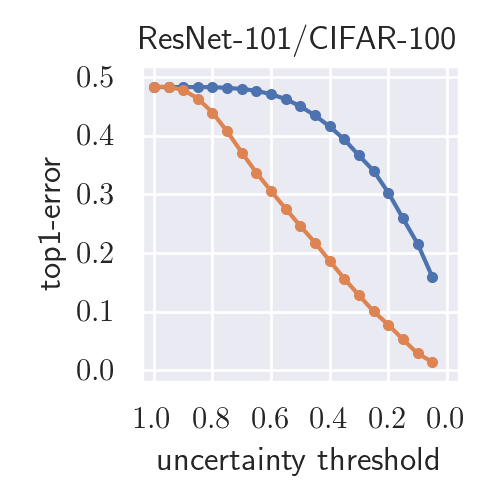

In [13]:
fig2, ax2 = plt.subplots(1, 1, figsize=(2.5, 2.5))
ax2.plot(uncert_thresholds2, top1_errors_uncalib2, marker='.')
ax2.plot(uncert_thresholds2, top1_errors2, marker='.')
ax2.set_xlabel(r'uncertainty threshold')
ax2.set_ylabel(r'top1-error')
ax2.set_xlim(1.04, -0.04)
ax2.set_ylim(-0.02, 0.52)
ax2.set_xticks((np.arange(0.0, 1.1, step=0.2)))
ax2.set_yticks((np.arange(0.0, 0.51, step=0.1)))
ax2.set_title(r'ResNet-101/CIFAR-100')
ax2.set_aspect(2)
fig2.tight_layout()
fig2.show()
fig2.savefig('uncert_thresh_resnet101.pdf', bbox_inches='tight', pad_inches=0)

<IPython.core.display.Javascript object>


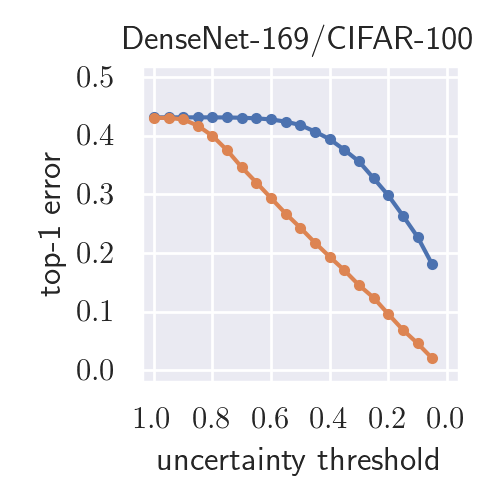

In [14]:
fig3, ax3 = plt.subplots(1, 1, figsize=(2.5, 2.5))
ax3.plot(uncert_thresholds3, top1_errors_uncalib3, marker='.')
ax3.plot(uncert_thresholds3, top1_errors3, marker='.')
ax3.set_xlabel(r'uncertainty threshold')
ax3.set_ylabel(r'top-1 error')
ax3.set_xlim(1.04, -0.04)
ax3.set_ylim(-0.02, 0.52)
ax3.set_yticks((np.arange(0.0, 0.5, step=0.1)))
ax3.set_xticks((np.arange(0.0, 1.1, step=0.2)))
ax3.set_yticks((np.arange(0.0, 0.51, step=0.1)))
ax3.set_title(r'DenseNet-169/CIFAR-100')
ax3.set_aspect(2)
fig3.tight_layout()
fig3.show()
fig3.savefig('uncert_thresh_densenet169.pdf', bbox_inches='tight', pad_inches=0)

<IPython.core.display.Javascript object>


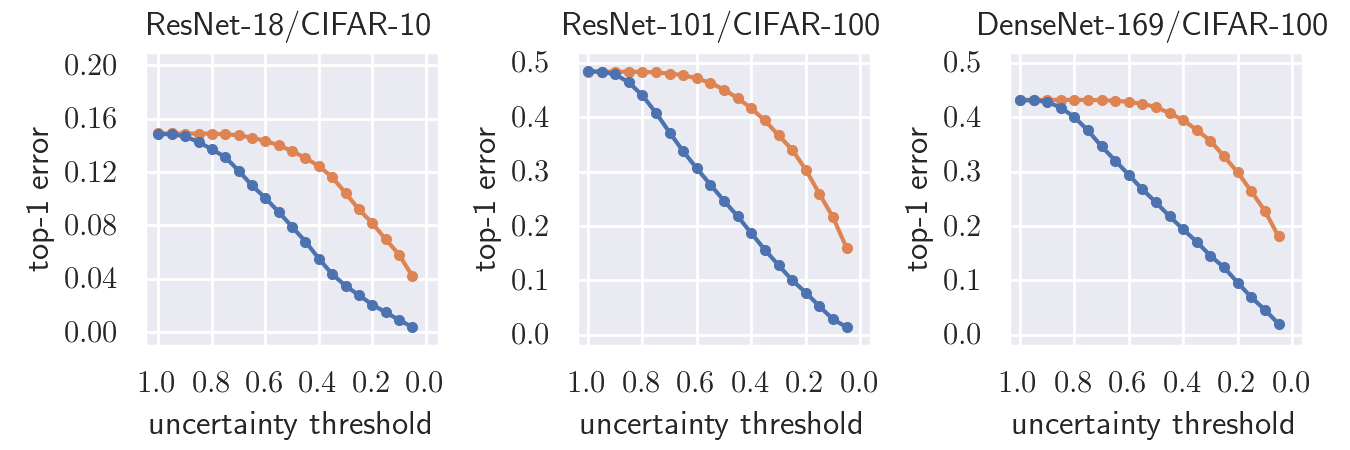

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(3*2.25, 2.25))

ax[0].plot(uncert_thresholds1, top1_errors_uncalib1, '.-', color='C1')
ax[0].plot(uncert_thresholds1, top1_errors1, '.-')
ax[0].set_xlabel(r'uncertainty threshold')
ax[0].set_ylabel(r'top-1 error')
ax[0].set_xlim(1.05, -0.05)
ax[0].set_ylim(-0.01, 0.21)
ax[0].set_xticks((np.arange(0.0, 1.1, step=0.2)))
ax[0].set_yticks((np.arange(0.0, 0.21, step=0.04)))
ax[0].set_title(r'ResNet-18/CIFAR-10')
ax[0].set_aspect(5)

ax[1].plot(uncert_thresholds2, top1_errors_uncalib2, '.-', color='C1')
ax[1].plot(uncert_thresholds2, top1_errors2, '.-')
ax[1].set_xlabel(r'uncertainty threshold')
ax[1].set_ylabel(r'top-1 error')
ax[1].set_xlim(1.04, -0.04)
ax[1].set_ylim(-0.02, 0.52)
ax[1].set_xticks((np.arange(0.0, 1.1, step=0.2)))
ax[1].set_yticks((np.arange(0.0, 0.51, step=0.1)))
ax[1].set_title(r'ResNet-101/CIFAR-100')
ax[1].set_aspect(2)

ax[2].plot(uncert_thresholds3, top1_errors_uncalib3, '.-', color='C1')
ax[2].plot(uncert_thresholds3, top1_errors3, '.-')
ax[2].set_xlabel(r'uncertainty threshold')
ax[2].set_ylabel(r'top-1 error')
ax[2].set_xlim(1.04, -0.04)
ax[2].set_ylim(-0.02, 0.52)
ax[2].set_yticks((np.arange(0.0, 0.5, step=0.1)))
ax[2].set_xticks((np.arange(0.0, 1.1, step=0.2)))
ax[2].set_yticks((np.arange(0.0, 0.51, step=0.1)))
ax[2].set_title(r'DenseNet-169/CIFAR-100')
ax[2].set_aspect(2)

fig.tight_layout()
fig.savefig('uncert_thresh.pdf', bbox_inches='tight', pad_inches=0)